# Effective Convergence
*24 January 2020*

In this notebook, we'll be using an idea I didn't realize up till now, that we can define the effective convergence as:
$$\kappa_\mathrm{eff} = \frac{1}{2} \nabla \cdot \vec\alpha$$
(thanks to [Gilman+ 2019](https://arxiv.org/pdf/1901.11031.pdf)).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from scipy import fftpack

In [3]:
from lenstronomy.LensModel.lens_model import LensModel

In [4]:
from lenstronomy.Plots import lens_plot

Note that we're updating from `lenstronomy 1.0.1` to `1.3.0` (this new version has tNFW profiles). This might break a little bit of backward compatibility with our older codebase. We'll see.

In [5]:
from helpers import CustomImage

In [6]:
# These are the (somewhat arbitrary) lens system settings used to create the sample image:
zl = 0.2
xs = [0,2]
ys = [10,-2]
redshifts = [.2,.25]

In [7]:
# Now we'll try something more intense
np.random.seed(123)

zl = 0.2
xs, ys, redshifts = [], [], []
for i in range(20):
    xs.append( np.random.uniform(-15,15) )
    ys.append( np.random.uniform(-15,15) )
    redshifts.append( np.random.uniform(0,1) ) 

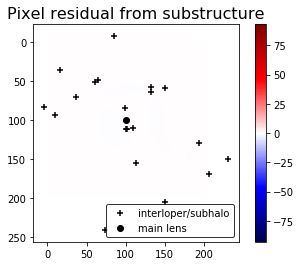

In [8]:
blankimg = CustomImage([],[],[], zl=zl)

myimg = CustomImage(xs, ys, redshifts, zl=zl, m=1e7)

vmin = np.min(myimg.image - blankimg.image)
vmax = np.max(myimg.image - blankimg.image)
vmin = min(vmin, -vmax)
vmax = max(vmax, -vmin)

plt.imshow(myimg.image - blankimg.image, vmin=vmin, vmax=vmax, cmap='seismic')
plt.colorbar()
plt.scatter([myimg.x_to_pix(x,z) for x,z in zip(xs, redshifts)],
            [myimg.x_to_pix(y,z) for y,z in zip(ys, redshifts)], color='black', marker='+', label='interloper/subhalo')
plt.scatter([myimg.x_to_pix(0)], [myimg.x_to_pix(0)], color='black', label='main lens')

leg = plt.legend()
#leg.get_frame().set_linewidth(3)
leg.get_frame().set_edgecolor('k')

plt.title('Pixel residual from substructure', size=16)

#plt.savefig('imgs/jan26_sample_residuals.pdf')

plt.show()

In [9]:
# myimg.lens_model_mp.ray_shooting(0,0,myimg.kwargs_lens)
# myimg.lens_model_mp.ray_shooting(-10,0,myimg.kwargs_lens)
# myimg.pixel_grid.map_pix2coord(140, 0)

# alphamat_x = np.zeros((myimg.pixnum, myimg.pixnum))
# alphamat_y = np.zeros((myimg.pixnum, myimg.pixnum))
# alphamat_mag = np.zeros((myimg.pixnum, myimg.pixnum))
# for xpix in range(myimg.pixnum):
#     for ypix in range(myimg.pixnum):
#         image_xy = myimg.pixel_grid.map_pix2coord(xpix, ypix) # in angle units
#         source_xy = myimg.lens_model_mp.ray_shooting(image_xy[0], image_xy[1], myimg.kwargs_lens)
#         alphamat_x[xpix,ypix] = image_xy[0] - source_xy[0]
#         alphamat_y[xpix,ypix] = image_xy[1] - source_xy[1]
#         alphatmat_mag = np.sqrt(alphamat_x[xpix,ypix]**2 + alphamat_y[xpix,ypix]**2)

# divmat = np.gradient(alphamat_x, myimg.pixsize)[0] + np.gradient(alphamat_y, myimg.pixsize)[1]
# curlmat = np.gradient(alphamat_y, myimg.pixsize)[0] - np.gradient(alphamat_x, myimg.pixsize)[1]

In [10]:
divmat, curlmat = myimg.calc_div_curl()

In [11]:
divmat_blank, curlmat_blank = blankimg.calc_div_curl()

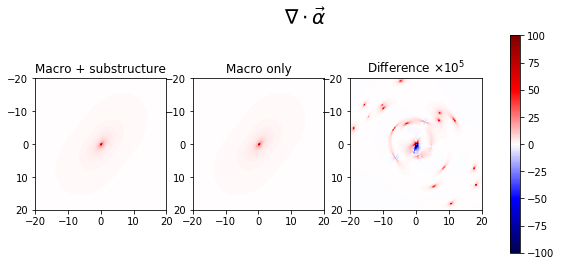

In [12]:
fig, axs = plt.subplots(1,3, figsize=(10,4))

ratio = 1e5
# check that title is correctly set to the ratio

#vmin = min(np.min(divmat), np.min(divmat_blank), ratio*np.min(divmat-divmat_blank))
#vmax = max(np.max(divmat), np.max(divmat_blank), ratio*np.max(divmat-divmat_blank))
vmax=100
vmin = -vmax

ext = 0.5*myimg.pixnum*myimg.pixsize

im = axs[0].imshow(divmat.T, vmin=vmin, vmax=vmax, extent=[-ext,ext,ext,-ext], cmap='seismic')
axs[0].set_title('Macro + substructure')
axs[1].imshow(divmat_blank.T, vmin=vmin, vmax=vmax, extent=[-ext,ext,ext,-ext], cmap='seismic')
axs[1].set_title('Macro only')
im2 = axs[2].imshow(ratio*(divmat-divmat_blank).T, 
              vmin=vmin, vmax=vmax,
              extent=[-ext,ext,ext,-ext], cmap='seismic')
axs[2].set_title('Difference $\\times 10^5$')

plt.colorbar(im, ax=axs.ravel().tolist())

fig.suptitle(r'$\nabla\cdot\vec\alpha$', size=20)

#plt.savefig('imgs/jan26_sample500_divergences.png')
plt.show()

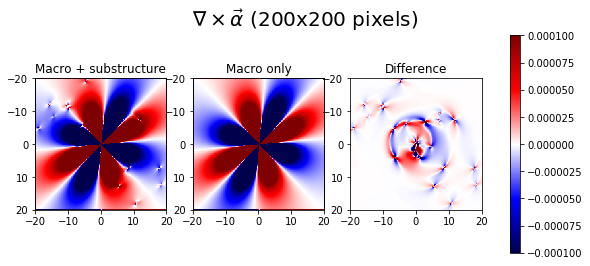

In [33]:
fig, axs = plt.subplots(1,3, figsize=(10,4))

vmin = -1e-4#min(np.min(curlmat), np.min(curlmat_blank))
vmax = 1e-4#max(np.max(curlmat), np.max(curlmat_blank))

ext = 0.5*myimg.pixnum*myimg.pixsize

im = axs[0].imshow(curlmat.T, vmin=vmin, vmax=vmax, extent=[-ext,ext,ext,-ext],cmap='seismic')
axs[0].set_title('Macro + substructure')
axs[1].imshow(curlmat_blank.T, vmin=vmin, vmax=vmax, extent=[-ext,ext,ext,-ext],cmap='seismic')
axs[1].set_title('Macro only')
axs[2].imshow((curlmat-curlmat_blank).T, vmin=vmin, vmax=vmax, extent=[-ext,ext,ext,-ext],cmap='seismic')
axs[2].set_title('Difference')
plt.colorbar(im, ax=axs.ravel().tolist())

fig.suptitle(r'$\nabla\times\vec\alpha$ (200x200 pixels)', size=20)

#plt.savefig('imgs/jan27_sample20_curls.png')

plt.show()

## Test if curl pattern is a numerical error

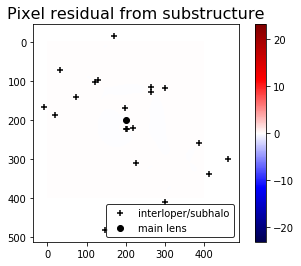

In [14]:
blankimg2 = CustomImage([],[],[], zl=zl, pixsize=0.1, pixnum=400)

myimg2 = CustomImage(xs, ys, redshifts, zl=zl, m=1e7, pixsize=0.1, pixnum=400)

vmin = np.min(myimg2.image - blankimg2.image)
vmax = np.max(myimg2.image - blankimg2.image)
vmin = min(vmin, -vmax)
vmax = max(vmax, -vmin)

plt.imshow(myimg2.image - blankimg2.image, vmin=vmin, vmax=vmax, cmap='seismic')
plt.colorbar()
plt.scatter([myimg2.x_to_pix(x,z) for x,z in zip(xs, redshifts)],
            [myimg2.x_to_pix(y,z) for y,z in zip(ys, redshifts)], color='black', marker='+', label='interloper/subhalo')
plt.scatter([myimg2.x_to_pix(0)], [myimg2.x_to_pix(0)], color='black', label='main lens')

leg = plt.legend()
#leg.get_frame().set_linewidth(3)
leg.get_frame().set_edgecolor('k')

plt.title('Pixel residual from substructure', size=16)

#plt.savefig('imgs/jan26_sample_residuals.pdf')

plt.show()

In [16]:
divmat2, curlmat2 = myimg2.calc_div_curl()
divmat2_blank, curlmat2_blank = blankimg2.calc_div_curl()

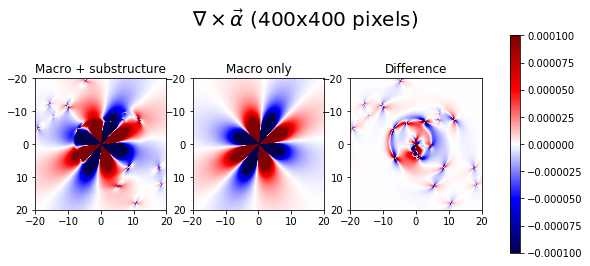

In [34]:
fig, axs = plt.subplots(1,3, figsize=(10,4))

vmin = -1e-4#min(np.min(curlmat), np.min(curlmat_blank))
vmax = 1e-4#max(np.max(curlmat), np.max(curlmat_blank))

ext = 0.5*myimg.pixnum*myimg.pixsize

im = axs[0].imshow(curlmat2.T, vmin=vmin, vmax=vmax, extent=[-ext,ext,ext,-ext],cmap='seismic')
axs[0].set_title('Macro + substructure')
axs[1].imshow(curlmat2_blank.T, vmin=vmin, vmax=vmax, extent=[-ext,ext,ext,-ext],cmap='seismic')
axs[1].set_title('Macro only')
axs[2].imshow((curlmat2-curlmat2_blank).T, vmin=vmin, vmax=vmax, extent=[-ext,ext,ext,-ext],cmap='seismic')
axs[2].set_title('Difference')
plt.colorbar(im, ax=axs.ravel().tolist())

fig.suptitle(r'$\nabla\times\vec\alpha$ (400x400 pixels)', size=20)

#plt.savefig('imgs/jan27_sample20_curls_double.png')

plt.show()

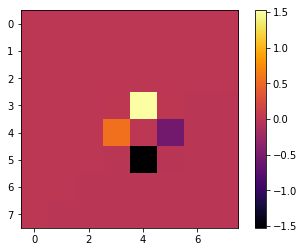

In [35]:
plt.imshow(((divmat2-divmat2_blank).T)[200-4:200+4,200-4:200+4], cmap='inferno')
plt.colorbar()

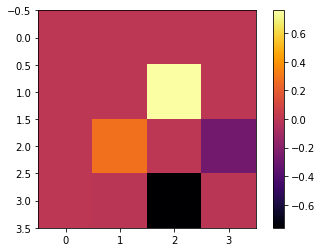

In [36]:
plt.imshow(((divmat-divmat_blank).T)[100-2:100+2,100-2:100+2], cmap='inferno')
plt.colorbar()

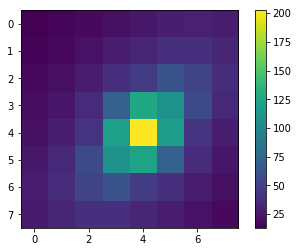

In [25]:
plt.imshow(((divmat2).T)[200-4:200+4,200-4:200+4])
plt.colorbar()

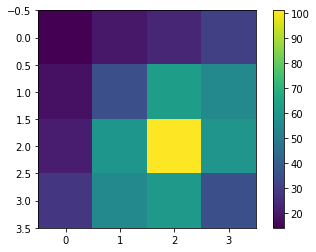

In [26]:
plt.imshow(((divmat).T)[100-2:100+2,100-2:100+2])
plt.colorbar()

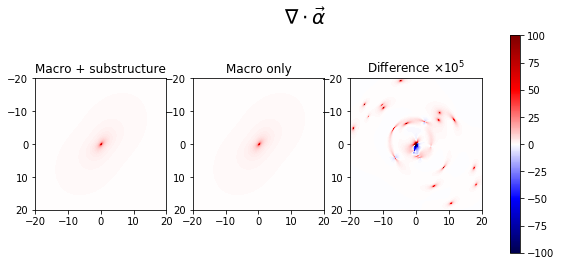

In [19]:
fig, axs = plt.subplots(1,3, figsize=(10,4))

ratio = 1e5
# check that title is correctly set to the ratio

#vmin = min(np.min(divmat), np.min(divmat_blank), ratio*np.min(divmat-divmat_blank))
#vmax = max(np.max(divmat), np.max(divmat_blank), ratio*np.max(divmat-divmat_blank))
vmax=100
vmin = -vmax

ext = 0.5*myimg.pixnum*myimg.pixsize

im = axs[0].imshow(divmat2.T, vmin=vmin, vmax=vmax, extent=[-ext,ext,ext,-ext], cmap='seismic')
axs[0].set_title('Macro + substructure')
axs[1].imshow(divmat2_blank.T, vmin=vmin, vmax=vmax, extent=[-ext,ext,ext,-ext], cmap='seismic')
axs[1].set_title('Macro only')
im2 = axs[2].imshow(ratio*(divmat2-divmat2_blank).T, 
              vmin=vmin, vmax=vmax,
              extent=[-ext,ext,ext,-ext], cmap='seismic')
axs[2].set_title('Difference $\\times 10^5$')

plt.colorbar(im, ax=axs.ravel().tolist())

fig.suptitle(r'$\nabla\cdot\vec\alpha$', size=20)

#plt.savefig('imgs/jan26_sample500_divergences.png')
plt.show()

# Old cells

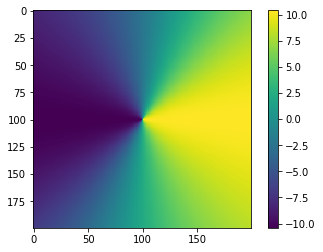

In [10]:
plt.imshow(myimg.alphamat_x.T); plt.colorbar()

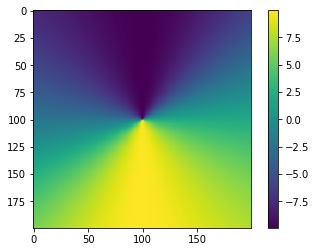

In [11]:
plt.imshow(myimg.alphamat_y.T); plt.colorbar()